# Body Mass Index Classifier
**Dataset downloaded from [here](https://www.kaggle.com/datasets/sjagkoo7/bmi-body-mass-index)**
## Goals:
- Gain experience with feature engineering
- Gain experience with EDA
- Predict BMI-Index 
- Build classifier with at least 85% accuracy
## Contents:
* [EDA](#EDA)
* [Preprocessing](#Preprocessing)
* [Model Selection and Baseline Testing](#Model-Selection-and-Baseline-Testing)
* [Final Testing](#Final-Testing)

In [142]:
import numpy as np
import pandas as pd

In [143]:
df = pd.read_csv('bmi-data/bmi_train.csv')

In [144]:
df.head()

,Gender,Height,Weight,Index
0,Male,161,89,4
1,Male,179,127,4
2,Male,172,139,5
3,Male,153,104,5
4,Male,165,68,2


In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Gender  400 non-null    object
 1   Height  400 non-null    int64 
 2   Weight  400 non-null    int64 
 3   Index   400 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 12.6+ KB


In [146]:
df.isna().sum()

Gender    0
Height    0
Weight    0
Index     0
dtype: int64

In [147]:
# Check cardinality
df.nunique()

Gender      2
Height     60
Weight    110
Index       6
dtype: int64

### EDA

In [148]:
import os
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

# Removes warnings in current job (RandomizedSearch CV)
warnings.filterwarnings("ignore")
# Removes warnings in spawned jobs
os.environ['PYTHONWARNINGS']='ignore'
# Set plot size
plt.rcParams['figure.figsize'] = [15, 6]
# Set palette
sns.set_palette('pastel')

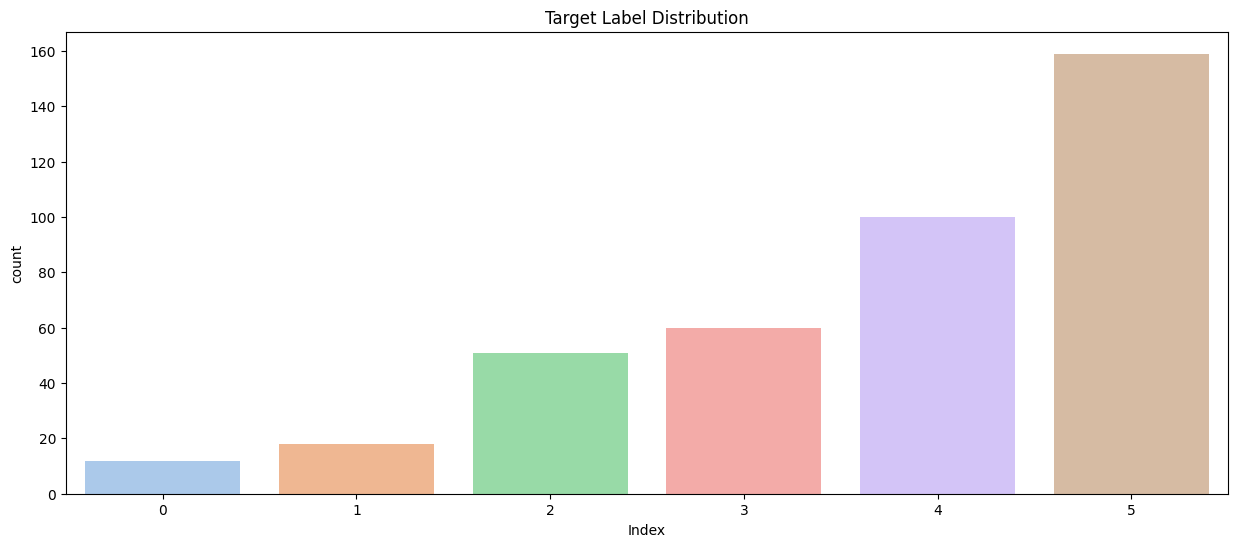

In [149]:
# Target label distribution
plt.title('Target Label Distribution')
sns.countplot(x=df['Index'])
plt.show()

# 0: Extremly Weak
# 1: Weak
# 2: Normal
# 3: Overweight
# 4: Obesity
# 5: Extremly Obesity

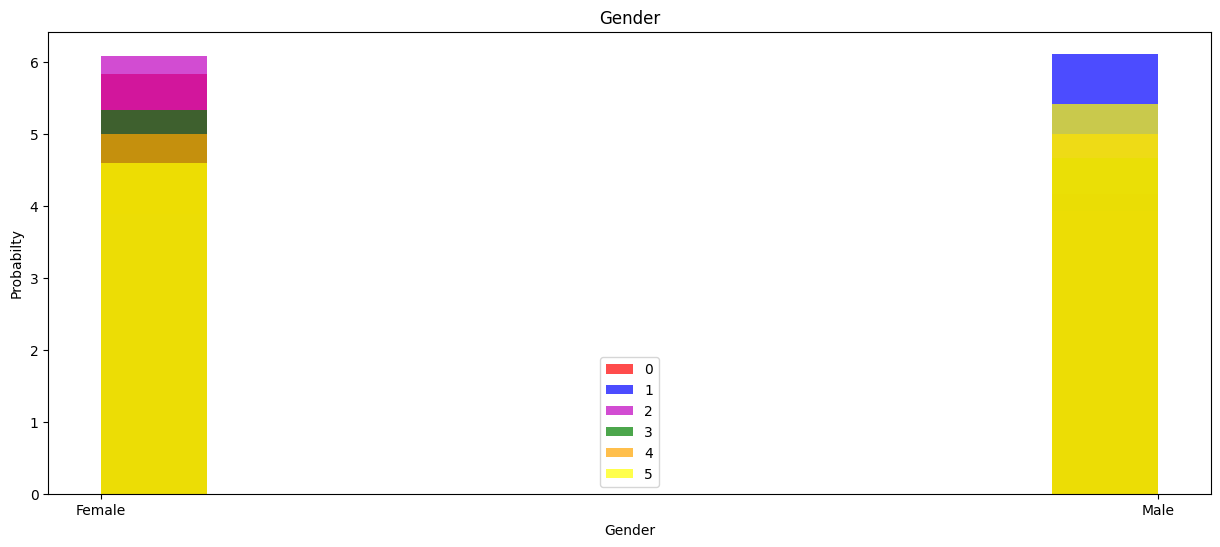

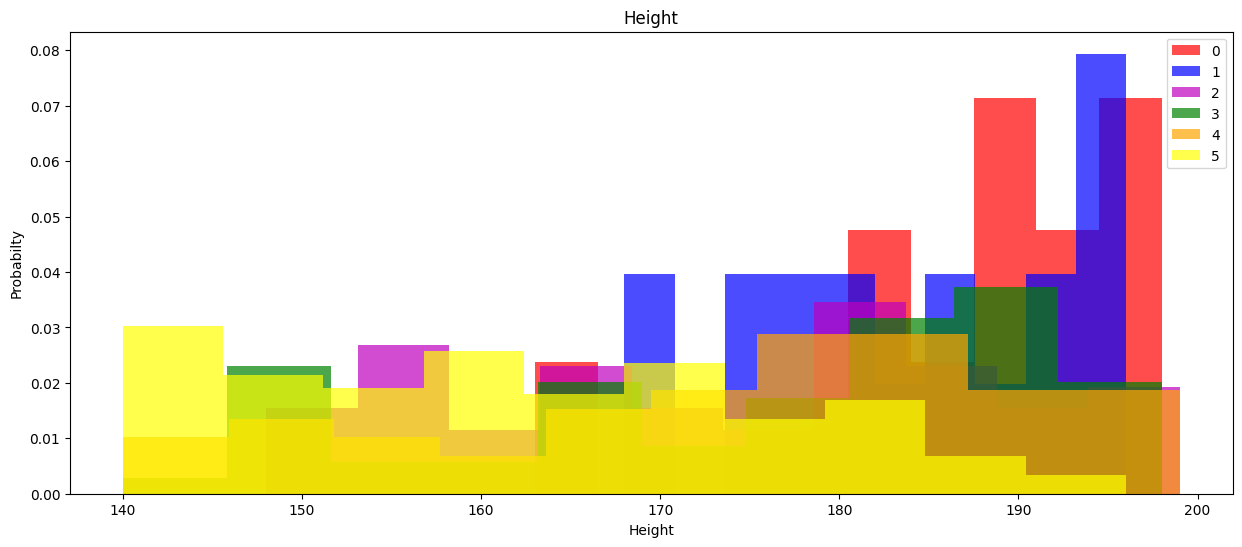

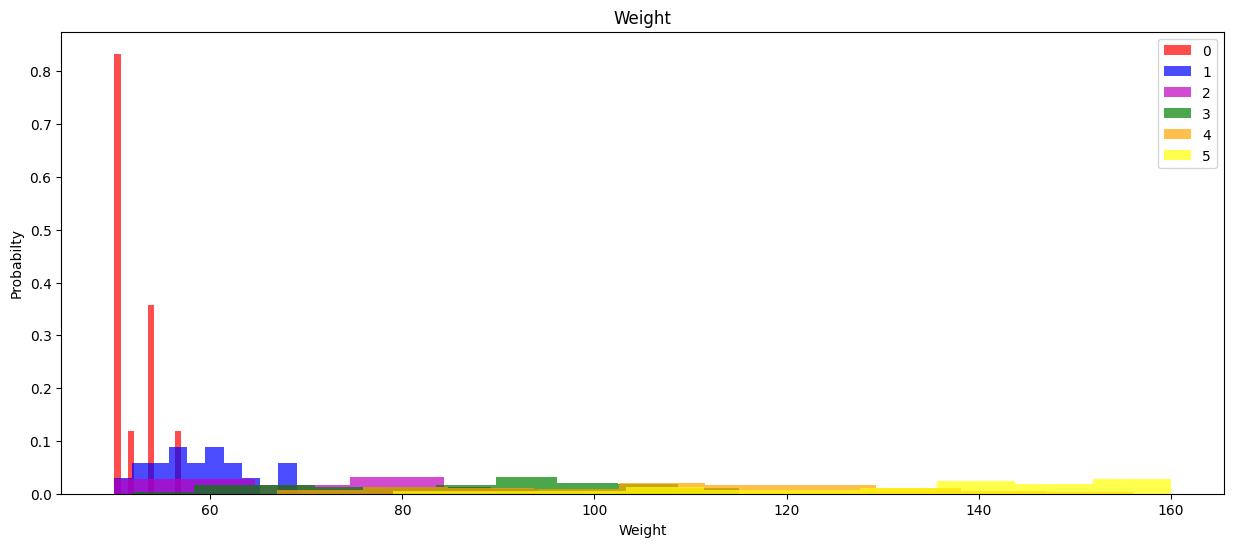

In [150]:
# Create new dataframes for each target label
target_dfs = [df[df['Index'] == i] for i in range(6)]
colours = ['r', 'b', 'm', 'g', 'orange', 'yellow']

# Plot histograms for each target dataframe
for feature in df.columns[:-1]:
    for index, x in enumerate(target_dfs):
        plt.title(feature)
        plt.hist(x[feature], color=colours[index], alpha=0.7, label=index, density=True)

    plt.xlabel(feature)
    plt.ylabel('Probabilty')
    plt.legend()
    plt.show()    

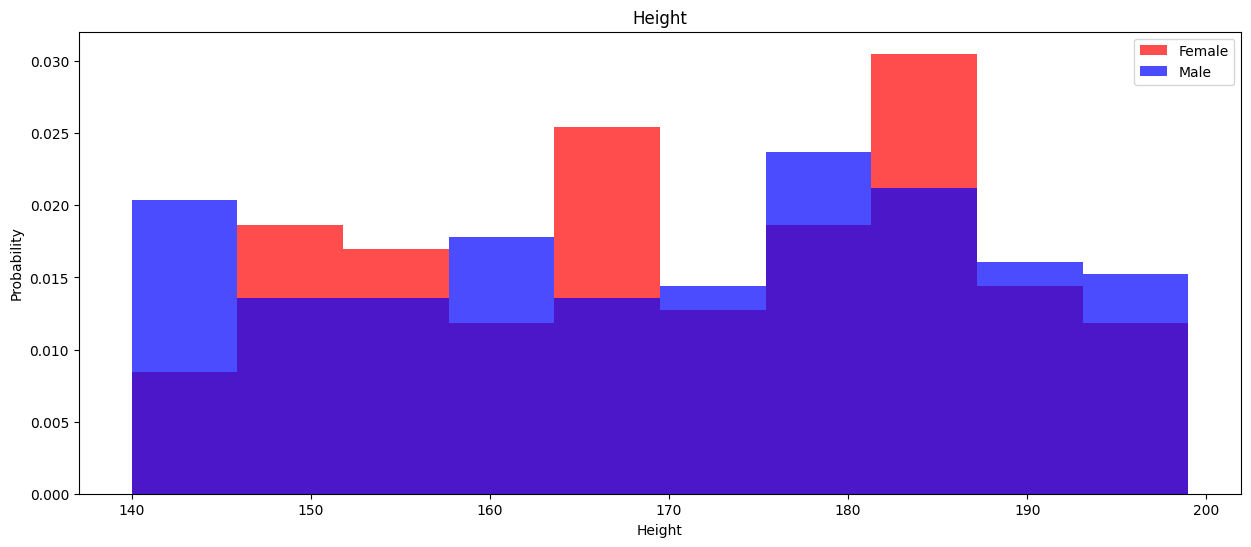

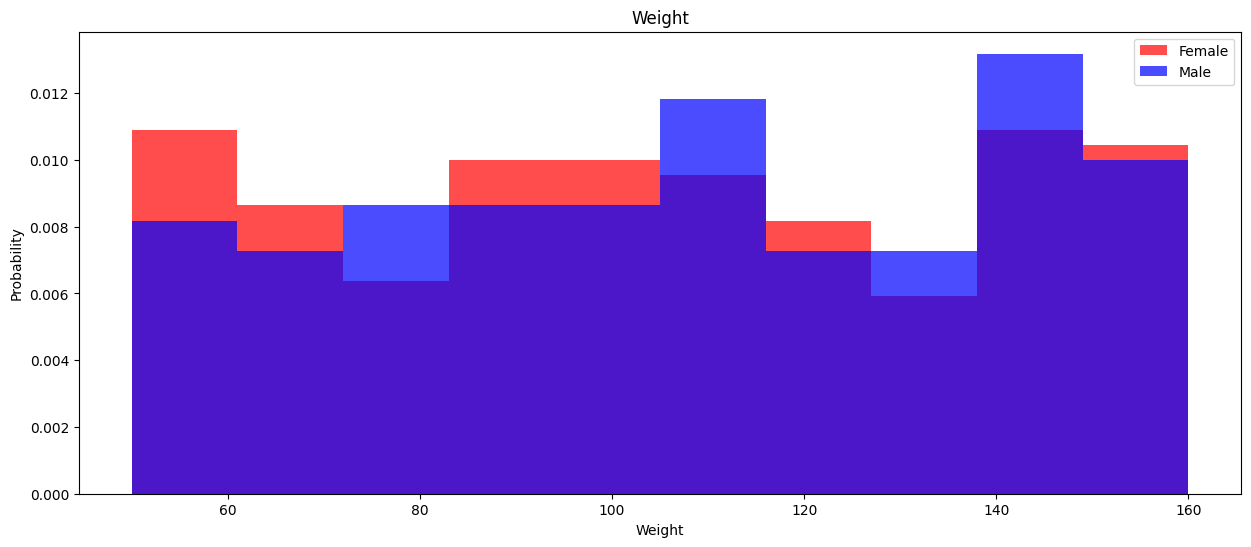

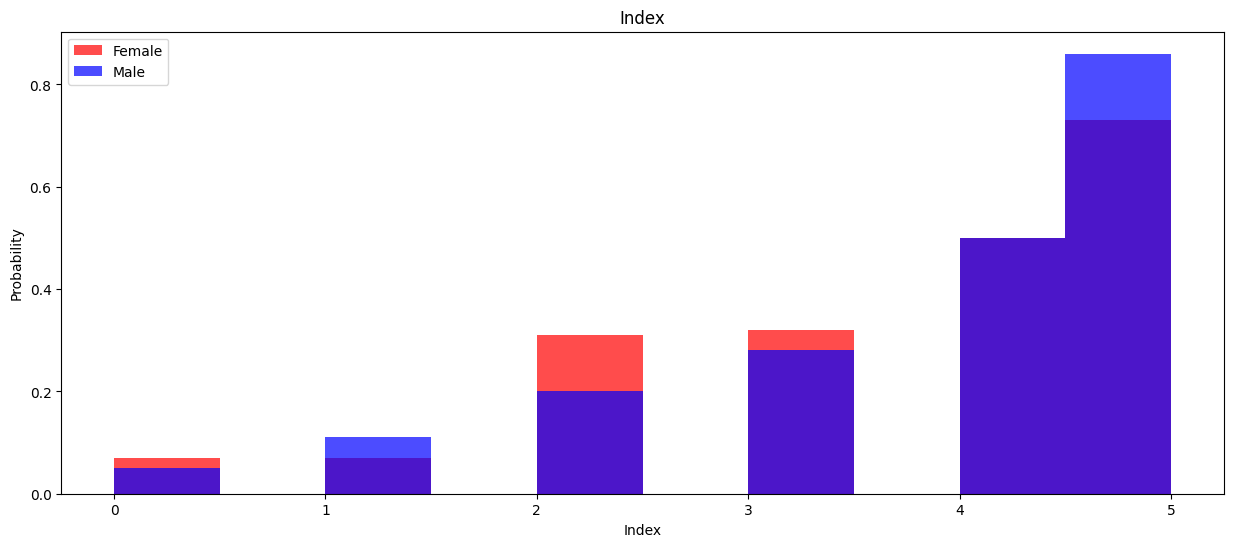

In [151]:
f = df[df['Gender'] == 'Female']
m = df[df['Gender'] == 'Male']

# Plot histograms comparing each feature with gender
for feature in df.columns:
    if feature == 'Gender':
        continue
    
    plt.title(feature)
    plt.hist(f[feature], alpha=0.7, color='r', density=True, label='Female')
    plt.hist(m[feature], alpha=0.7, color='b', density=True, label='Male')
    plt.xlabel(feature)
    plt.ylabel('Probability')
    plt.legend()
    plt.show()

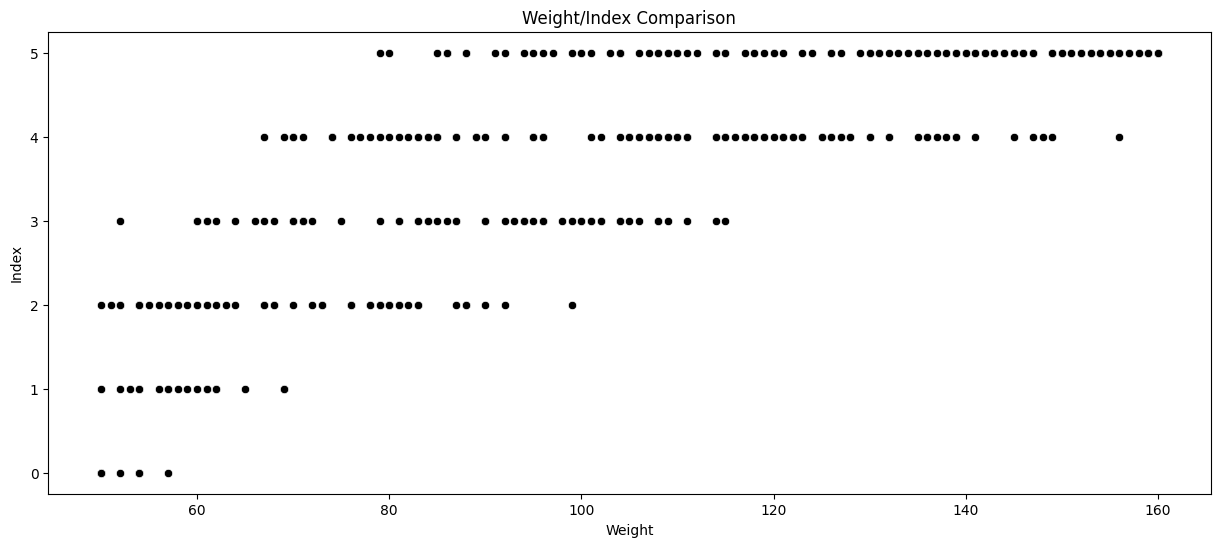

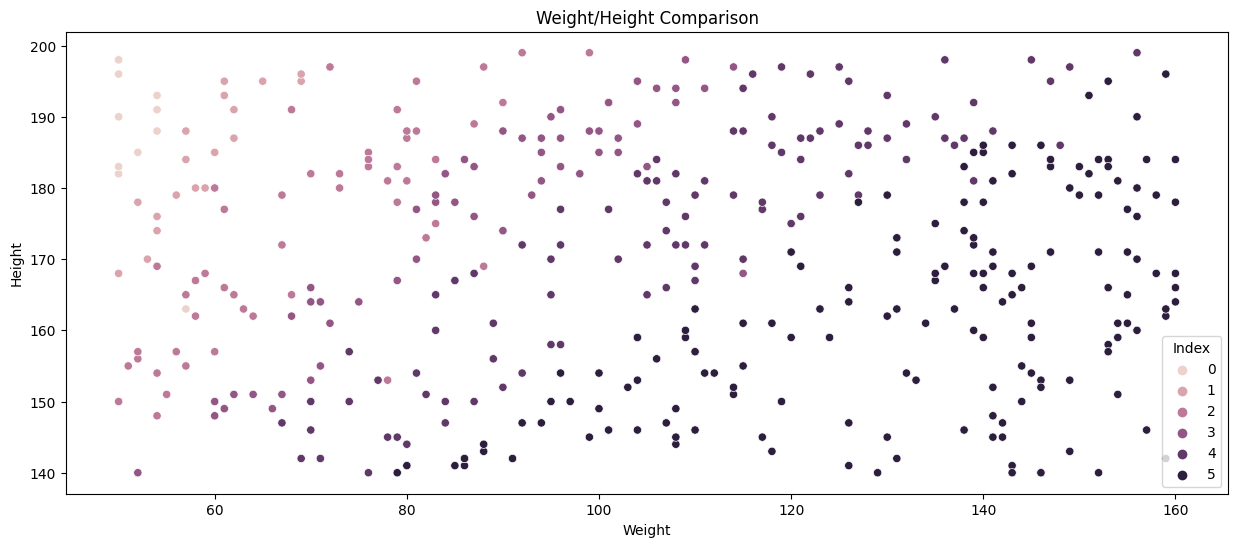

In [152]:
# Scatter plot based on weight/index
plt.title('Weight/Index Comparison')
sns.scatterplot(x=df['Weight'], y=df['Index'], color='k')
plt.show()

# Scatter plot based on weight/heigh from each target dataframe
plt.title('Weight/Height Comparison')
sns.scatterplot(data=df, x='Weight', y='Height', hue='Index')
plt.show()

### Preprocessing

In [153]:
def preprocessing(dataframe):
    dataframe = dataframe.copy()
    
    # Calculate BMI
    values = []
    for index, row in dataframe.iterrows():
        bmi = 703 * (row['Weight'] / (row['Height'] ** 2))
        values.append(bmi)
    
    # Add -Weight column
    dataframe['-Weight'] = dataframe['Weight'].apply(lambda x: 1 if x <= 70 else 0)
    # OneHot Gender column
    dataframe['Gender'] = dataframe['Gender'].apply(lambda x: 0 if x == 'Male' else 1)
    # Add BMI columns
    dataframe['BMI'] = values
    
    return dataframe

In [154]:
X = preprocessing(df)

In [155]:
X.head(3)

,Gender,Height,Weight,Index,-Weight,BMI
0,0,161,89,4,0,2.413757
1,0,179,127,4,0,2.786461
2,0,172,139,5,0,3.303035


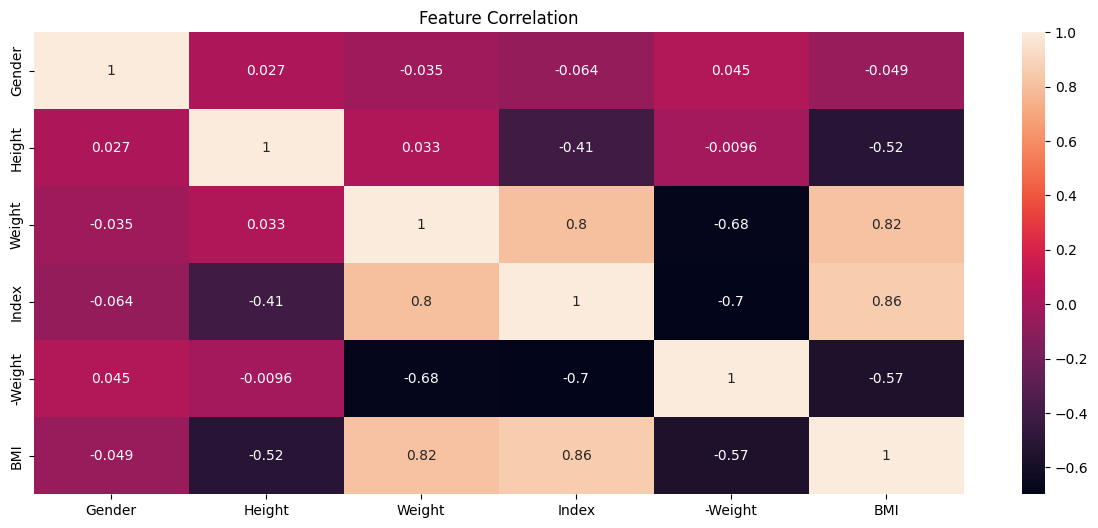

In [156]:
# Feature correlation
plt.title('Feature Correlation')
sns.heatmap(X.corr(), annot=True, cmap='rocket')
plt.show()

### Model Selection and Baseline Testing

In [157]:
from sklearn.model_selection import train_test_split

In [158]:
X, y = X.drop(['Index'], axis=1), X['Index']

In [159]:
X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.30, random_state=42)
X_cv, X_test, y_cv, y_test = train_test_split(X_, y_, test_size=0.20, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_cv shape: {X_cv.shape}")
print(f"y_cv shape: {y_cv.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (280, 5)
y_train shape: (280,)
X_cv shape: (96, 5)
y_cv shape: (96,)
X_test shape: (24, 5)
y_test shape: (24,)


In [160]:
from sklearn.preprocessing import MinMaxScaler

In [161]:
s = MinMaxScaler()

In [162]:
# Scale X_train
X_train = pd.DataFrame(s.fit_transform(X_train), columns=X_train.columns)
# Transform X_cv
X_cv = pd.DataFrame(s.transform(X_cv), columns=X_cv.columns)

In [163]:
X_train.head(1)

,Gender,Height,Weight,-Weight,BMI
0,1.0,0.728814,0.236364,0.0,0.153405


In [164]:
X_cv.head(1)

,Gender,Height,Weight,-Weight,BMI
0,1.0,0.389831,0.118182,1.0,0.169113


In [165]:
# Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

In [166]:
models = {
    'XGB': XGBClassifier(),
    'RandomForest': RandomForestClassifier(),
    'GradientBoost': GradientBoostingClassifier()
}

In [167]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, log_loss, roc_auc_score, confusion_matrix

In [168]:
# Feature importance
def plot_feature_importance(importances, feature_names, model):
    pd.Series(importances, index=feature_names).plot(kind='barh')
    plt.title(f"{model} Feature Importance")
    plt.show()


def display_metrics(y_true, y_hat, y_hat_probas, model):
    print(f"Model: {model}")
    print(f"Accuracy score: {accuracy_score(y_true, y_hat)}")
    print(f"Recall score: {recall_score(y_true, y_hat, average='macro')}")
    print(f"Precision score: {precision_score(y_true, y_hat, average='macro')}")
    try:
        print(f"Log loss {log_loss(y_true, y_hat_probas, labels=y_true.unique())}")
        print(f"ROC AUC: {roc_auc_score(y_true, y_hat_probas, multi_class='ovr')}")
    except Exception as e:
        print(f"Error: {e}")

Model: XGB
Accuracy score: 0.9895833333333334
Recall score: 0.9583333333333334
Precision score: 0.986111111111111
Log loss 0.09827604804622847
ROC AUC: 0.98914496628691


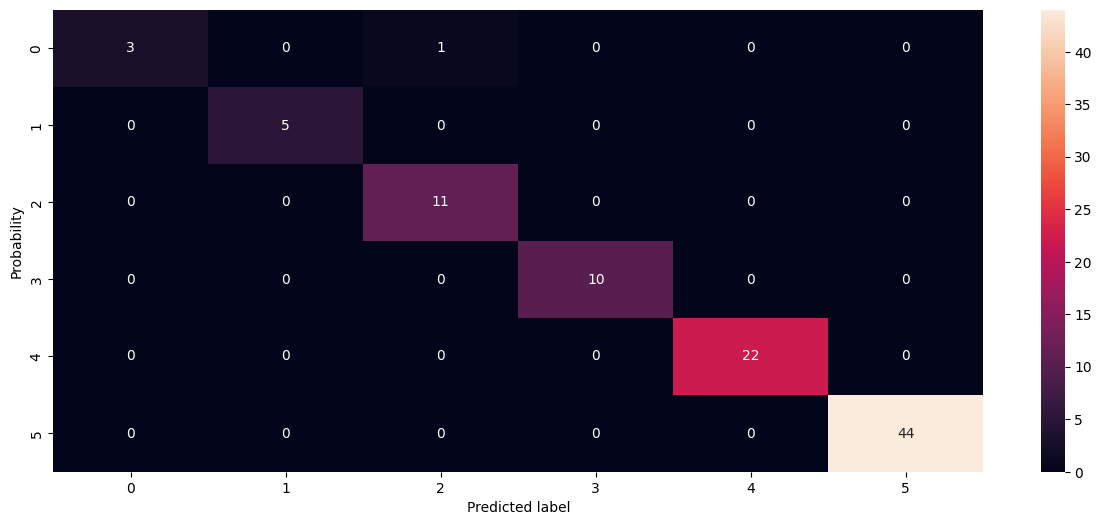

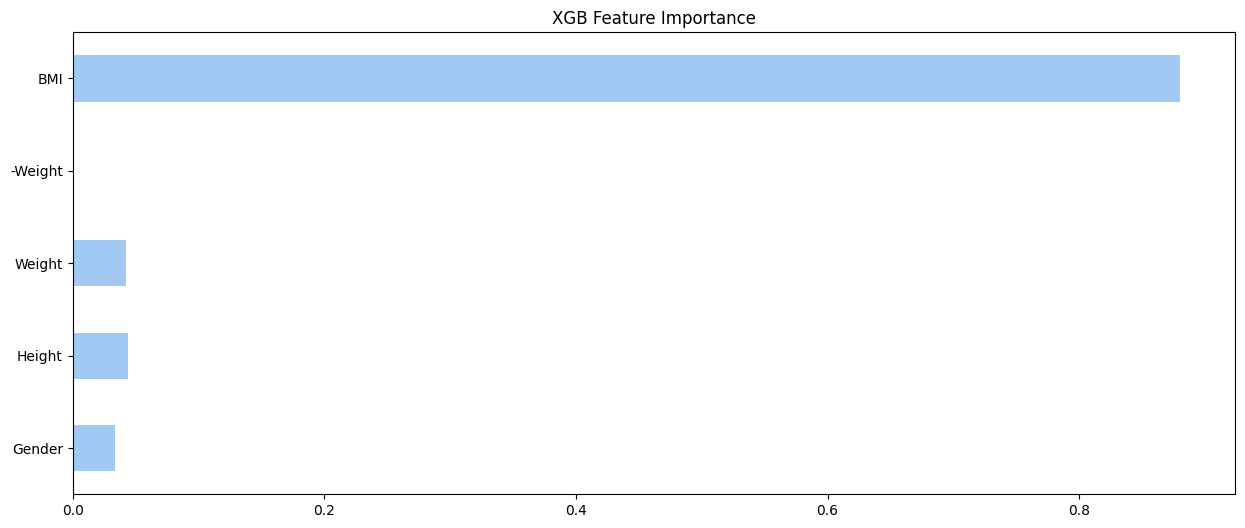

Model: RandomForest
Accuracy score: 0.9791666666666666
Recall score: 0.9431818181818182
Precision score: 0.9696969696969697
Log loss 0.48173782037925705
ROC AUC: 0.975330546663927


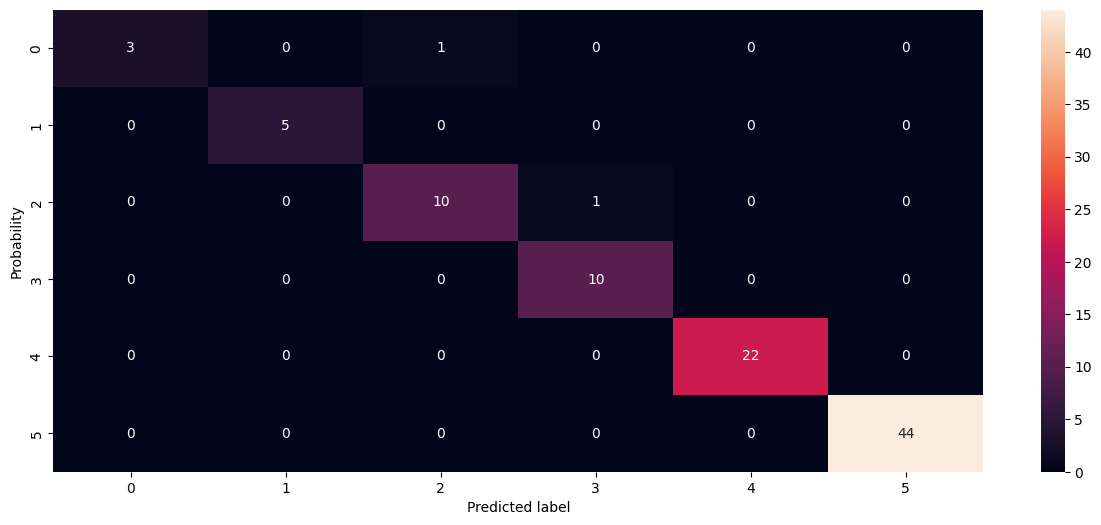

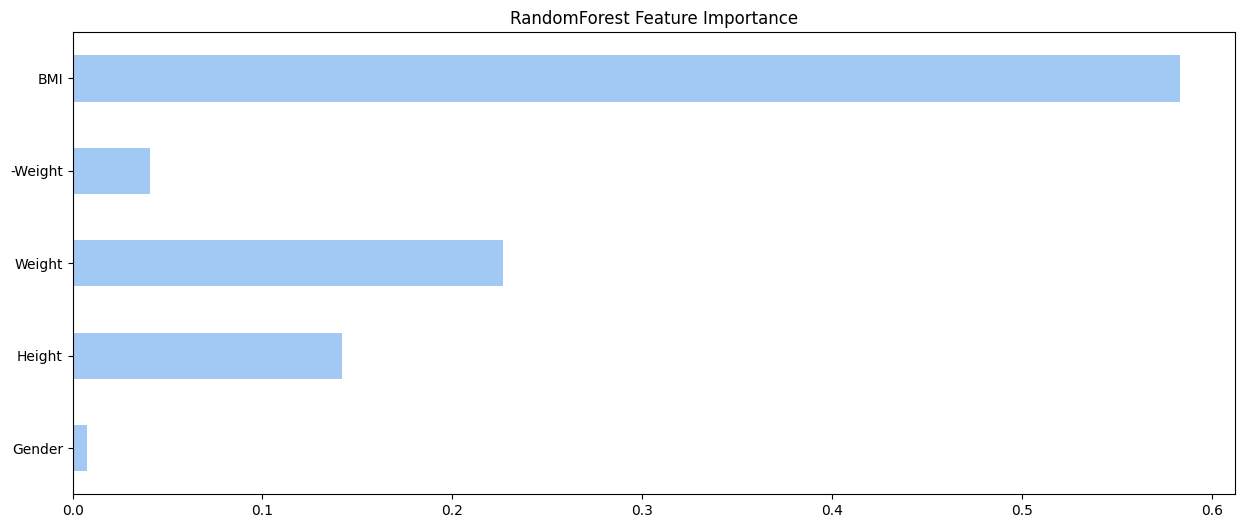

Model: GradientBoost
Accuracy score: 0.9583333333333334
Recall score: 0.9356060606060606
Precision score: 0.9465811965811967
Log loss 0.27364239258207945
ROC AUC: 0.9913889447457223


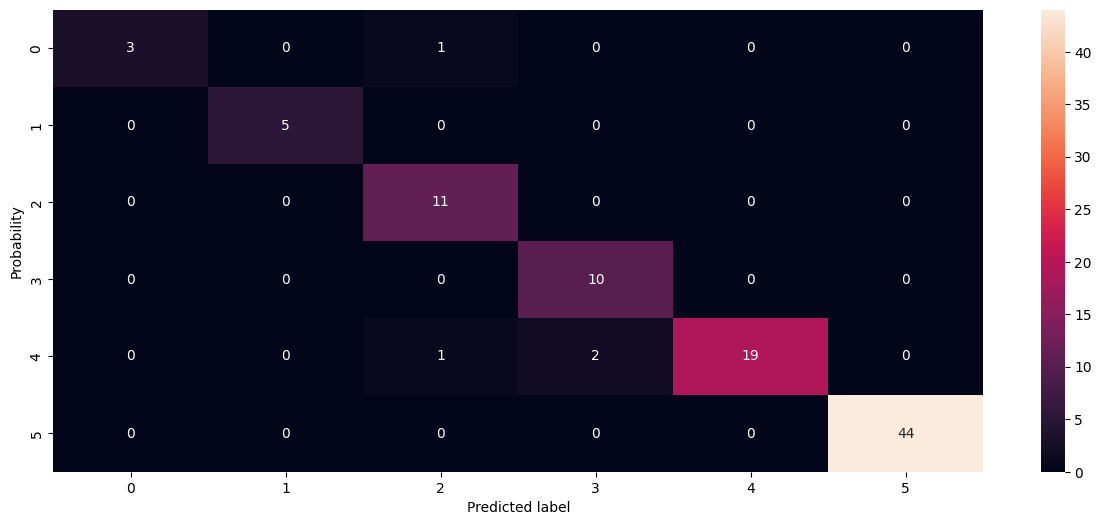

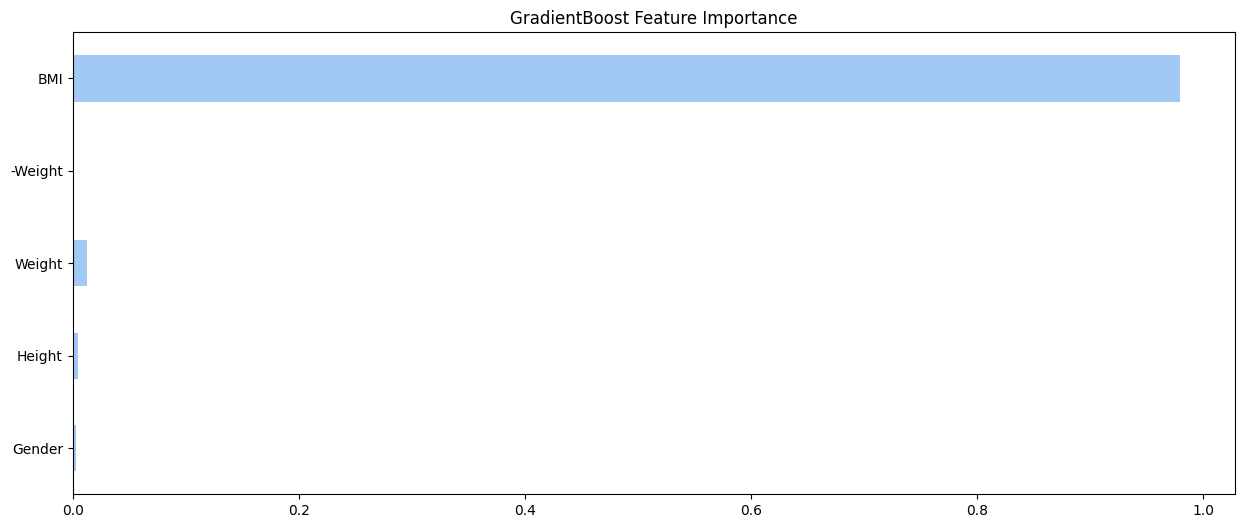

In [169]:
# Get baseline metrics for each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_cv)
    y_probas = model.predict_proba(X_cv)
    
    # Display metrics
    display_metrics(y_cv, y_pred, y_probas, name)
    
    # Plot confusion matrix
    cm = confusion_matrix(y_cv, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='rocket')
    plt.xlabel('Predicted label')
    plt.ylabel('Probability')
    plt.show()
    
    # Plot feature importance if available
    if name != 'LogisticReg':
        feature_names = X_train.columns
        importances = model.feature_importances_
        plot_feature_importance(importances, feature_names, name)

### Parameter Tuning

In [170]:
from sklearn.model_selection import GridSearchCV

In [171]:
model_params = {
    # XBG parameters
    'XGB': {
        'learning_rate': [0.05, 0.10, 0.15, 0.30],
        'max_depth': np.arange(1, 16, 5),
        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
        'colsample_bytree': [0.3, 0.4, 0.5, 0.7]
    },

    # RandomForest parameters
    'RandomForest': {
        'criterion': ['entropy', 'gini'],
        'max_depth': range(2, 21, 5),
        'max_features': ['auto', 'sqrt', 'log2'],
        'n_estimators': [90, 100, 130, 150, 200, 250]
    },
    
    # GradientBooster parameters
    'GradientBoost': {
        'learning_rate': [1, 0.5, 0.01],
        'n_estimators': [1, 2, 4, 6, 100],
        'max_depth': range(5, 9),
        'max_features': list(range(1, X_train.shape[1]))
    }
}

In [172]:
fitted_models = {}

for name, model in models.items():
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=model_params[name],
        n_jobs=-1,
        cv=5,
        scoring='accuracy',
        verbose=True
    )
    
    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_cv)
    y_probas = grid_search.predict_proba(X_cv)
    
    # Display metrics
    display_metrics(y_cv, y_pred, y_probas, name)
    print()
    
    # Store best fitted estimators
    fitted_models[name] = {
        'Model': grid_search.best_estimator_,
        'Score': grid_search.best_score_
    }

print(f"\nFitting complete!")

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Model: XGB
Accuracy score: 0.9895833333333334
Recall score: 0.9583333333333334
Precision score: 0.986111111111111
Log loss 0.1541072329630059
ROC AUC: 0.9853580562659846

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Model: RandomForest
Accuracy score: 0.9791666666666666
Recall score: 0.9431818181818182
Precision score: 0.9696969696969697
Log loss 0.4825263189919899
ROC AUC: 0.9755160655355074

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Model: GradientBoost
Accuracy score: 0.9791666666666666
Recall score: 0.9431818181818182
Precision score: 0.9696969696969697
Log loss 0.119107417046377
ROC AUC: 0.9630960338680926


Fitting complete!


In [173]:
# Check CV score for each model
for name, d in fitted_models.items():
    print(f"{name} score: {d['Score']}")

XGB score: 0.9714285714285713
RandomForest score: 0.9571428571428571
GradientBoost score: 0.9678571428571429


### Final Testing

In [174]:
import pickle

In [175]:
def save_model(model):
    with open('model.pkl', 'wb') as f:
        pickle.dump(model, f)


def load_model(file):
    with open('model.pkl', 'rb') as f:
        return pickle.load(f)

In [176]:
clf = fitted_models['XGB']['Model']

# Save model
save_model(clf)

# Load model
clf = load_model('model.pkl')

In [177]:
# Process/transform test set
final_test = preprocessing(X_test)
final_test = pd.DataFrame(s.transform(final_test), columns=final_test.columns)

In [178]:
final_test.head(1)

,Gender,Height,Weight,-Weight,BMI
0,1.0,0.898305,0.727273,0.0,0.341781


In [179]:
# Fit classifier
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [180]:
# Make predictions on test set
test_pred = clf.predict(final_test)
test_probas = clf.predict_proba(final_test)

In [181]:
# Results
display_metrics(y_test, test_pred, test_probas, 'XGB')

Model: XGB
Accuracy score: 0.9583333333333334
Recall score: 0.975
Precision score: 0.9714285714285713
Error: The number of classes in labels is different from that in y_pred. Classes found in labels: [1 2 3 4 5]
